# Phase-Amplitude Coupling (PAC) Source Analysis for MEG Data

This notebook performs source-level PAC analysis on MEG data for saccade events.

## Analysis workflow:
1. **Data Loading**: Load source estimates and PAC results
2. **Morphing**: Transform individual data to fsaverage space
3. **ROI Analysis**: Extract PAC values for regions of interest
4. **Statistical Analysis**: Test significance across brain regions
5. **Visualisation**: Create brain plots and statistical summaries

**Author**: Philip Sulewski (psulewski@uos.de)

In [116]:
# Import required libraries
import sys
import os
import numpy as np
from pathlib import Path
import scipy
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import mne
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib import colors as mcolors

# Configure plotting
sns.set_context("poster")
color_peak = "#de5733ff"
plt.rcParams['svg.fonttype'] = 'none'

print("Libraries imported successfully!")

Libraries imported successfully!


## Configuration and Setup

In [181]:
# Subject and data configuration
subjects = [1,2,3,4,5]
event_types = ['saccade']
method = "beamformer"
surrogate_method = "single_cut"

# Memorability split configuration
use_memsplit = False  # Set to True to load memorability split data
memsplit_ratio = "40-40"  # e.g., "50-50" or "25-25" (only used if use_memsplit=True)

# Duration split configuration
use_dursplit = True  # Set to True to load duration split data
duration_threshold = 300  # Threshold in ms (e.g., 350) (only used if use_dursplit=True)
use_offset_locked = True  # Set to True to use offset-locked PAC (time-locked to fixation end)

# Frequency bands
theta_freqs = (3, 8)
gamma_freqs = (40, 140)

# Time window for PAC analysis
time_window = [0.15, 0.4]

# Data paths
SUBJECTS_DIR = "/Users/atlas/avs/rawdir/"
avs_dir = "/Users/atlas/avs"
data_dir = "/Users/atlas/share_psulewski/psulewski/active-visual-semantics-MEG/results/fullrun/analysis/gazetime/revision_nature/ica/stc/filter_0.2_200/"

print(f"Analysis configuration:")
print(f"- Subjects: {subjects}")
print(f"- Theta band: {theta_freqs[0]}-{theta_freqs[1]} Hz")
print(f"- Gamma band: {gamma_freqs[0]}-{gamma_freqs[1]} Hz")
print(f"- Time window: {time_window[0]}-{time_window[1]} s")
print(f"- Memorability split: {'YES (' + memsplit_ratio + ')' if use_memsplit else 'NO'}")
print(f"- Duration split: {'YES (' + str(duration_threshold) + ' ms)' if use_dursplit else 'NO'}")
print(f"- Offset-locked: {'YES' if use_offset_locked else 'NO'}")

Analysis configuration:
- Subjects: [1, 2, 3, 4, 5]
- Theta band: 3-8 Hz
- Gamma band: 40-140 Hz
- Time window: 0.15-0.4 s
- Memorability split: NO
- Duration split: YES (300 ms)
- Offset-locked: YES


## ROI Definitions

Define anatomical regions of interest based on the Glasser atlas.

In [119]:
# Define compound ROI labels for analysis
compound_labels = {
    "early": ["early"],  # Early visual cortex
    "parietal": ["midparietal", "parietal"],
    "lateral": ["midlateral", "lateral"],  # Lateral visual cortex
    "ventral": ["midventral", "ventral"],  # Ventral visual cortex
    "HC": ["H"],  # Hippocampus 
    "EC": ["EC"],  # Entorhinal cortex
    "FEF": ["FEF"],  # Frontal eye fields
    "dlPFC": ["8C", "8Av", "i6-8", "s6-8", "SFL", "8BL", "9p", "9a", "8Ad", 
              "p9-46v", "a9-46v", "46", "9-46d"],  # Dorsolateral prefrontal cortex
    "OFC": ["47s", "47m", "a47r", "11l", "13l", "a10p", "p10p", "10pp", 
            "10d", "OFC", "pOFC"],  # Orbitofrontal cortex
    "infFC": ["45", "IFJp", "IFJa", "IFSp", "IFSa", "47l", "p47r"],  # Inferior frontal cortex
    "mPFC": ["33pr", "p24pr", "a24pr", "p24", "a24", "p32pr", "a32pr", 
             "d32", "p32", "s32", "8BM", "9m", "10v", "10r", "25"]  # Medial prefrontal cortex
}

print(f"Defined {len(compound_labels)} ROI categories:")
for roi, labels in compound_labels.items():
    print(f"- {roi}: {len(labels)} sub-regions")

Defined 11 ROI categories:
- early: 1 sub-regions
- parietal: 2 sub-regions
- lateral: 2 sub-regions
- ventral: 2 sub-regions
- HC: 1 sub-regions
- EC: 1 sub-regions
- FEF: 1 sub-regions
- dlPFC: 13 sub-regions
- OFC: 11 sub-regions
- infFC: 7 sub-regions
- mPFC: 15 sub-regions


## Data Loading Functions

In [124]:
def load_subject_data(subject, event_type, data_dir, avs_dir, 
                      use_memsplit=False, memsplit_ratio="50-50",
                      use_dursplit=False, duration_threshold=350,
                      use_offset_locked=False):
    """
    Load source estimate and PAC results for a single subject.
    
    Parameters
    ----------
    subject : int
        Subject number
    event_type : str
        Event type (e.g., 'saccade')
    data_dir : str
        Path to PAC results directory
    avs_dir : str
        Path to source estimates directory
    use_memsplit : bool
        Whether to load memorability split data
    memsplit_ratio : str
        Memorability split ratio (e.g., "50-50" or "25-25")
    use_dursplit : bool
        Whether to load duration split data
    duration_threshold : int
        Duration threshold in ms (e.g., 350)
    use_offset_locked : bool
        Whether data uses offset-locked PAC
        
    Returns
    -------
    stc : mne.SourceEstimate
        Source estimate object
    pac_results : pd.DataFrame
        PAC results dataframe
    has_split : bool
        Whether the loaded data contains split groups (memsplit or dursplit)
    """
    sub_name = f"as{subject:02d}"
    
    # Load source estimate
    stc_fname = (f"{avs_dir}/population_codes/{sub_name}/source_space/{method}/"
                f"glasser/ori_normal/hem_both/filter_0.2_200/ica/{sub_name}a_stcs_{event_type}")
    stc = mne.read_source_estimate(stc_fname)
    
    # Build PAC results filename
    base_fname = (f"pac_results_{subject}_stc_{event_type}_"
                  f"{theta_freqs[0]}-{theta_freqs[1]}_"
                  f"{gamma_freqs[0]}-{gamma_freqs[1]}_"
                  f"{time_window[0]}-{time_window[1]}_"
                  f"['saccade', 'fixation', 'saccade_post', 'fixation_post']_"
                  f"{surrogate_method}")
    
    # Add split suffix if requested (priority: duration > memorability)
    if use_dursplit:
        pac_results_fname = f"{base_fname}_dursplit_{duration_threshold}ms"
    elif use_memsplit:
        memsplit_str = memsplit_ratio.replace("/", "-")
        pac_results_fname = f"{base_fname}_memsplit_{memsplit_str}"
    else:
        pac_results_fname = base_fname
    
    # Add offset suffix if requested
    if use_offset_locked:
        pac_results_fname += "_offset"
    
    pac_results_fname += f"_cleaned"
    pac_results_fname += ".csv"
    
    pac_results_path = os.path.join(data_dir, sub_name, pac_results_fname)
    
    # Check if file exists
    if not os.path.exists(pac_results_path):
        raise FileNotFoundError(
            f"PAC results file not found: {pac_results_path}\n"
            f"Please check:\n"
            f"  - use_memsplit = {use_memsplit}\n"
            f"  - memsplit_ratio = {memsplit_ratio}\n"
            f"  - use_dursplit = {use_dursplit}\n"
            f"  - duration_threshold = {duration_threshold}\n"
            f"  - use_offset_locked = {use_offset_locked}\n"
            f"  - Expected filename: {pac_results_fname}"
        )
    
    # Load PAC results
    pac_results = pd.read_csv(pac_results_path)
    
    # Check if split_group column exists
    has_split = 'split_group' in pac_results.columns
    
    if (use_memsplit or use_dursplit) and not has_split:
        print(f"WARNING: Split requested but no 'split_group' column found in {pac_results_fname}")
    
    print(f"Loaded data for {sub_name}: {len(pac_results)} PAC values" + 
          (f" ({pac_results['split_group'].value_counts().to_dict()})" if has_split else ""))
    
    return stc, pac_results, has_split



def create_pac_stc(stc, pac_results, split_group=None):
    """
    Create source estimate with PAC values as data.
    
    Parameters
    ----------
    stc : mne.SourceEstimate
        Template source estimate
    pac_results : pd.DataFrame
        PAC results with 'channel' and 'pac' columns
    split_group : str, optional
        If provided, only use data from this split_group 
        (e.g., 'low_mem', 'high_mem', 'shorter_dur', 'longer_dur', or 'all')
        
    Returns
    -------
    pac_stc : mne.SourceEstimate
        Source estimate with PAC values
    """
    pac_stc = stc.copy()
    
    # Filter by split_group if specified
    if split_group is not None and 'split_group' in pac_results.columns:
        pac_results = pac_results[pac_results['split_group'] == split_group].copy()
    
    # Remove duplicates (keep last value)
    pac_results_clean = pac_results.sort_values(by="channel")
    pac_results_clean = pac_results_clean.drop_duplicates(subset="channel", keep="last")
    pac_results_clean = pac_results_clean.set_index("channel")
    
    # Prepare PAC data array
    pac_data = np.full((pac_stc.data.shape[0], 1), np.nan)
    
    # Fill PAC values into source estimate
    channels = np.concatenate((stc.vertices[0], stc.vertices[1]))
    for i, channel in enumerate(channels):
        if i in pac_results_clean.index:
            pac_data[i] = pac_results_clean.loc[i]["pac"]
    
    pac_stc.data = pac_data
    n_nans = np.isnan(pac_data).sum()
    
    if n_nans > 0 and split_group:
        print(f"  Warning: {n_nans} vertices without PAC values for {split_group}")
    elif n_nans > 0:
        print(f"Warning: {n_nans} vertices without PAC values")
    
    return pac_stc

print("Data loading functions defined.")

Data loading functions defined.


## Main Data Loading

Load source estimates and PAC results for all subjects.

In [184]:
print("Loading data for all subjects...")
print("=" * 50)

# Validate: only one split type allowed at a time
if use_dursplit and use_memsplit:
    raise ValueError(
        "ERROR: Cannot use both use_dursplit and use_memsplit simultaneously.\n"
        f"  use_dursplit = {use_dursplit}\n"
        f"  use_memsplit = {use_memsplit}\n"
        "Please set one to False in the configuration cell above."
    )

stc_dict = {}
pac_results_dict = {}
has_split_data = False
longer_stc_dict = {}
for subject in subjects:
    print(f"\nProcessing subject {subject}...")
    
    # Load data with split configuration
    stc, pac_results, has_split = load_subject_data(
        subject, 
        event_types[0], 
        data_dir, 
        avs_dir,
        use_memsplit=use_memsplit,
        memsplit_ratio=memsplit_ratio,
        use_dursplit=use_dursplit,
        duration_threshold=duration_threshold,
        use_offset_locked=use_offset_locked
    )
    
    # Track if any subject has split data
    if has_split:
        has_split_data = True
    
    # Create PAC source estimate
    if has_split and use_dursplit:
        # For duration split: create difference STC (longer - shorter)
        shorter_stc = create_pac_stc(stc, pac_results, split_group='short_dur')
        longer_stc = create_pac_stc(stc, pac_results, split_group='long_dur')
        print("MEAN LONGER STC DATA:", np.nanmean(longer_stc.data))
        # Create difference STC
        pac_stc = stc.copy()
        pac_stc.data = longer_stc.data - shorter_stc.data
   
        print(f"  Created difference STC (longer - shorter) for subject {subject}")
        print("MEAN PAC STC DATA:", np.nanmean(pac_stc.data))
    elif has_split and use_memsplit:
        # For memorability split: create difference STC (higher - lower)
        low_stc = create_pac_stc(stc, pac_results, split_group='low_mem')
        high_stc = create_pac_stc(stc, pac_results, split_group='high_mem')
        
        # Create difference STC
        pac_stc = stc.copy()
        pac_stc.data = high_stc.data - low_stc.data
        
        print(f"  Created difference STC (higher - lower) for subject {subject}")
  
    else:
        # No split: use all data
        pac_stc = create_pac_stc(stc, pac_results)
    
    stc_dict[subject] = pac_stc
    pac_results_dict[subject] = pac_results
    if has_split and use_dursplit:
        longer_stc_dict[subject] = longer_stc
        print(f"  Stored longer duration STC for subject {subject}")
print(f"\nData loading complete!")
#print(f"Source estimate shape: {stc_dict[1].data.shape}")
#print(f"Number of vertices: {len(stc_dict[1].vertices[0]) + len(stc_dict[1].vertices[1])}")

if has_split_data:
    if use_dursplit:
        print(f"\n*** Duration split data loaded successfully ***")
        print(f"Threshold: {duration_threshold} ms")
        print("Will perform additional shorter vs longer duration analysis.")
    elif use_memsplit:
        print(f"\n*** Memorability split data loaded successfully ***")
        print(f"Ratio: {memsplit_ratio}")
        print("Will perform additional higher vs lower memorability analysis.")
else:
    print(f"\n*** Standard (non-split) data loaded ***")

# Set variable name for compatibility with rest of notebook
has_memsplit_data = has_split_data and use_memsplit

Loading data for all subjects...

Processing subject 1...
Loaded data for as01: 15920 PAC values ({'long_dur': 7960, 'short_dur': 7960})
MEAN LONGER STC DATA: 1.5714179734296865
  Created difference STC (longer - shorter) for subject 1
MEAN PAC STC DATA: 0.2602506892917482
  Stored longer duration STC for subject 1

Processing subject 2...
Loaded data for as02: 15920 PAC values ({'long_dur': 7960, 'short_dur': 7960})
MEAN LONGER STC DATA: 4.8871373125370035
  Created difference STC (longer - shorter) for subject 2
MEAN PAC STC DATA: 1.2589178076706593
  Stored longer duration STC for subject 2

Processing subject 3...
Loaded data for as03: 15920 PAC values ({'long_dur': 7960, 'short_dur': 7960})
MEAN LONGER STC DATA: 5.214443593149009
  Created difference STC (longer - shorter) for subject 3
MEAN PAC STC DATA: 0.6117045960944457
  Stored longer duration STC for subject 3

Processing subject 4...
Loaded data for as04: 15920 PAC values ({'long_dur': 7960, 'short_dur': 7960})
MEAN LONGER 

## PAC Distribution Analysis

Visualise the distribution of PAC values before morphing to fsaverage space.

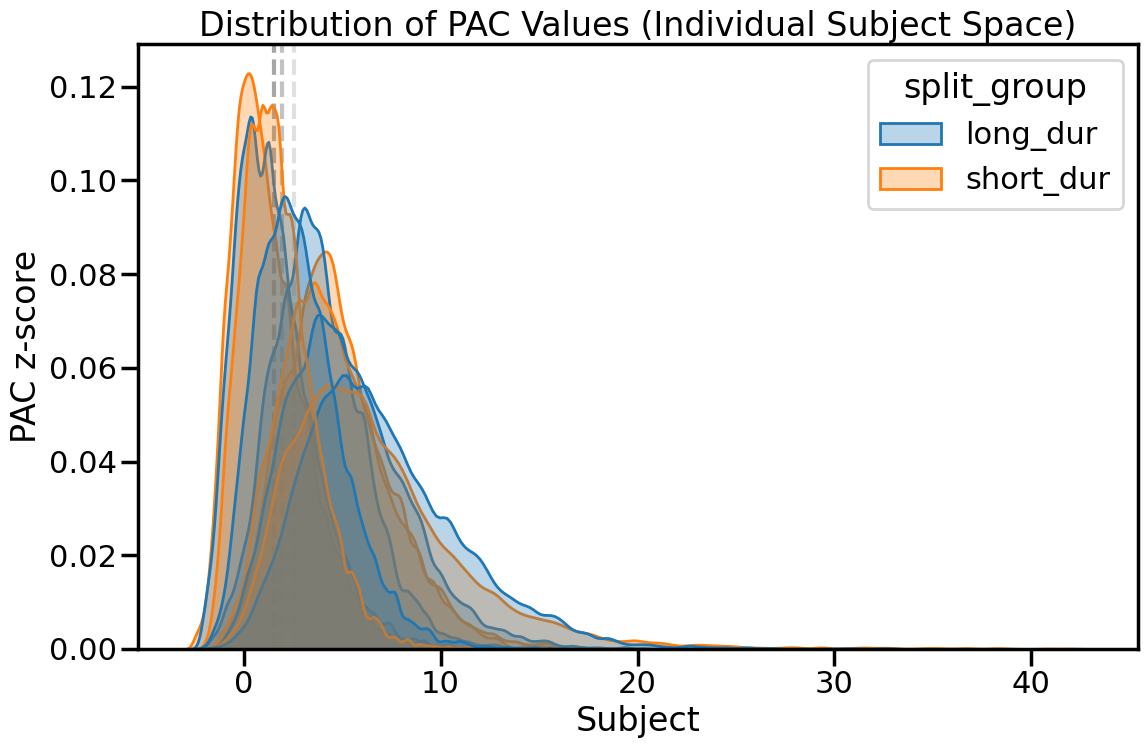


PAC Summary Statistics:
Mean: 3.924
Std: 3.589
Range: -2.565 to 41.969
Significant values (|z| > 1.65): 50707 / 70800 (71.6%)


In [126]:
plt.figure(figsize=(12, 8))
# make pac numeric

# make a kdeplot with hue for each subject
for subject in subjects:
    pac_data = pac_results_dict[subject]
    pac_data["pac"] = pd.to_numeric(pac_data["pac"], errors="coerce")
    # make a kdeplot with hue for each subject
    sns.kdeplot(data=pac_data, x="pac", fill=True, alpha=0.3, bw_adjust=0.5, hue="split_group" if has_split_data else None)

# Add significance thresholds
plt.axvline(x=1.56, color="grey", linestyle="--", alpha=0.7, label="p < 0.05", zorder = 0)
plt.axvline(x=1.96, color="darkgrey", linestyle="--", alpha=0.7, label="p < 0.01", zorder = 0) 
plt.axvline(x=2.56, color="lightgrey", linestyle="--", alpha=0.7, label="p < 0.001", zorder = 0)

plt.xlabel("Subject")
plt.ylabel("PAC z-score")
plt.title("Distribution of PAC Values (Individual Subject Space)")
#plt.ylim(-3, 20)
plt.tight_layout()
plt.show()

# Print summary statistics
all_pac_values = pd.concat([pac_results_dict[s]["pac"] for s in subjects])
print(f"\nPAC Summary Statistics:")
print(f"Mean: {all_pac_values.mean():.3f}")
print(f"Std: {all_pac_values.std():.3f}")
print(f"Range: {all_pac_values.min():.3f} to {all_pac_values.max():.3f}")
print(f"Significant values (|z| > 1.65): {(np.abs(all_pac_values) > 1.65).sum()} / {len(all_pac_values)} ({(np.abs(all_pac_values) > 1.65).mean()*100:.1f}%)")

## Morphing to fsaverage Space

Transform individual subject data to common fsaverage space for group analysis.

In [127]:
print("Morphing individual data to fsaverage space...")
print("=" * 50)

stcs_fsaverage = {}

for subject in subjects:
    print(f"Morphing subject {subject} to fsaverage...")
    stc = stc_dict[subject]
    
    # Compute morphing and apply
    morph = mne.compute_source_morph(
        stc, 
        subject_from=f"as{subject:02d}", 
        subject_to='fsaverage', 
        subjects_dir=SUBJECTS_DIR
    )
    stc_fsaverage = morph.apply(stc)
    stcs_fsaverage[subject] = stc_fsaverage

print("Morphing complete!")

Morphing individual data to fsaverage space...
Morphing subject 1 to fsaverage...
surface source space present ...
Computing morph matrix...
    Left-hemisphere map read.
    Right-hemisphere map read.
    7 smooth iterations done.
    8 smooth iterations done.
[done]
[done]
Morphing subject 2 to fsaverage...
surface source space present ...
Computing morph matrix...
    Left-hemisphere map read.
    Right-hemisphere map read.
    8 smooth iterations done.
    8 smooth iterations done.
[done]
[done]
Morphing subject 3 to fsaverage...
surface source space present ...
Computing morph matrix...
    Left-hemisphere map read.
    Right-hemisphere map read.
    8 smooth iterations done.
    8 smooth iterations done.
[done]
[done]
Morphing subject 4 to fsaverage...
surface source space present ...
Computing morph matrix...
    Left-hemisphere map read.
    Right-hemisphere map read.
    8 smooth iterations done.
    9 smooth iterations done.
[done]
[done]
Morphing subject 5 to fsaverage...
su

## Group-Level Analysis

Analyse PAC patterns across all subjects in fsaverage space.

Group data shape: (5, 20484)

Group-level PAC Results:
- Vertices with significant PAC: 18182
- Vertices with 2+ subjects: 12498
- Vertices with 3+ subjects: 5523
- Vertices with 4+ subjects: 1312
- Vertices with all 5 subjects: 126


/var/folders/27/cgtzfw9j75bc116gkfsr71v00000gn/T/ipykernel_66070/2782104880.py:16: RuntimeWarning: Mean of empty slice
  average_stc.data = np.nanmean(all_stcs, axis=0)[:, np.newaxis]


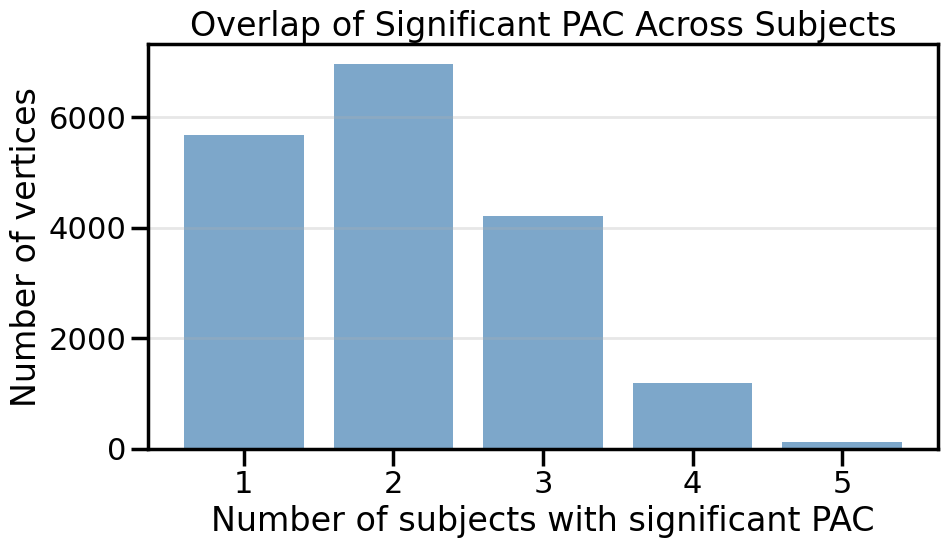

In [140]:
# Significance threshold
threshold = 1.65

# Collect all morphed data
all_stcs = np.array([stc.data[:, 0] for stc in stcs_fsaverage.values()])
print(f"Group data shape: {all_stcs.shape}")

# Count significant values per vertex
sig_count = np.sum(np.abs(all_stcs) > threshold, axis=0)

# Create count and average source estimates
sig_count_stc = list(stcs_fsaverage.values())[0].copy()
average_stc = list(stcs_fsaverage.values())[0].copy()

sig_count_stc.data = sig_count[:, np.newaxis]
average_stc.data = np.nanmean(all_stcs, axis=0)[:, np.newaxis]

# Report overlap statistics
sig_vertices = sig_count[sig_count > 0]
print(f"\nGroup-level PAC Results:")
print(f"- Vertices with significant PAC: {len(sig_vertices)}")
print(f"- Vertices with 2+ subjects: {np.sum(sig_count > 1)}")
print(f"- Vertices with 3+ subjects: {np.sum(sig_count > 2)}")
print(f"- Vertices with 4+ subjects: {np.sum(sig_count > 3)}")
print(f"- Vertices with all 5 subjects: {np.sum(sig_count > 4)}")

# Plot histogram of overlap counts
plt.figure(figsize=(10, 6))
unique_counts, count_frequencies = np.unique(sig_count[sig_count > 0], return_counts=True)
plt.bar(unique_counts, count_frequencies, alpha=0.7, color='steelblue')
plt.xlabel('Number of subjects with significant PAC')
plt.ylabel('Number of vertices')
plt.title('Overlap of Significant PAC Across Subjects')
plt.xticks(unique_counts)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## ROI Analysis Setup

Load anatomical labels and extract PAC values for each region of interest.

In [185]:
def load_roi_labels(subjects_dir, subject, compound_labels):
    """Load ROI labels for a subject."""
    labels_dict = {}
    
    for area in compound_labels.keys():
        labels_dict[area] = {}
        for hemi in ["lh", "rh"]:
            labels_dict[area][hemi] = []
            l_short = "R" if hemi == "rh" else "L"
            
            for roi in compound_labels[area]:
                label_fname = os.path.join(subjects_dir, subject, "label", 
                                         f"{hemi}.{l_short}_{roi}_ROI.label")
                
                if os.path.exists(label_fname):
                    label = mne.read_label(label_fname)
                    labels_dict[area][hemi].append(label)
                else:
                    print(f"Warning: Missing label {label_fname}")
    
    return labels_dict


def extract_pac_per_roi(stc_dict, labels_dict, compound_labels):
    """Extract PAC values per ROI for all subjects."""
    pac_per_label = pd.DataFrame()
    
    for subject in subjects:
        stc = stc_dict[subject]
        subject_labels = labels_dict[subject]
        
        for area, labels in subject_labels.items():
            for hemi, labels_list in labels.items():
                for label in labels_list:
                    # Extract data from label
                    stc_label = stc.in_label(label)
                    data_label = stc_label.data[:, 0]
                    
                    # Create dataframe entries
                    df_temp = pd.DataFrame({
                        'PAC': data_label,
                        'subject': subject,
                        'area': area,
                        'label': label.name,
                        'hemi': hemi
                    })
                    
                    pac_per_label = pd.concat([pac_per_label, df_temp], axis=0)
    
    return pac_per_label

print("ROI analysis functions defined.")

ROI analysis functions defined.


In [186]:
# Load labels for all subjects
print("Loading anatomical labels...")
labels_dict = {}
for subject in subjects:
    sub_name = f"as{subject:02d}"
    labels_dict[subject] = load_roi_labels(SUBJECTS_DIR, sub_name, compound_labels)

# Extract PAC values per ROI
print("\nExtracting PAC values per ROI...")
pac_per_label = extract_pac_per_roi(longer_stc_dict, labels_dict, compound_labels) #change to difference stc dict

# Remove NaN values and exclude problematic ROIs
pac_per_label = pac_per_label.dropna()
#pac_per_label = pac_per_label[pac_per_label["area"] != "EC"]  # Exclude EC due to data issues

print(f"\nROI analysis data shape: {pac_per_label.shape}")
print(f"Areas analysed: {list(pac_per_label['area'].unique())}")
print(f"\nData points per area:")
print(pac_per_label.groupby('area').size().sort_values(ascending=False))
print(pac_per_label.head())

Loading anatomical labels...

Extracting PAC values per ROI...

ROI analysis data shape: (16688, 5)
Areas analysed: ['early', 'parietal', 'lateral', 'ventral', 'HC', 'EC', 'FEF', 'dlPFC', 'OFC', 'infFC', 'mPFC']

Data points per area:
area
ventral     3062
dlPFC       2994
lateral     2606
mPFC        1730
parietal    1652
OFC         1504
early       1412
infFC       1090
HC           287
FEF          211
EC           140
dtype: int64
        PAC  subject   area              label hemi
0  6.259508        1  early  lh.L_early_ROI-lh   lh
1  9.183312        1  early  lh.L_early_ROI-lh   lh
2  4.894912        1  early  lh.L_early_ROI-lh   lh
3  5.031461        1  early  lh.L_early_ROI-lh   lh
4  4.798119        1  early  lh.L_early_ROI-lh   lh


## Statistical Analysis

Apply statistical tests to determine significance of PAC patterns across brain regions.

In [198]:
print("Performing statistical analysis...")
print("=" * 50)

# Convert PAC z-scores to p-values
pac_per_label["p_value"] = pac_per_label["PAC"].transform(
    lambda x: 2 * (1 - scipy.stats.norm.cdf(np.abs(x)))
)

# Apply FDR correction within each subject
def apply_fdr_per_subject(group):
    """Apply FDR correction within a subject group."""
    _, fdr_p = mne.stats.fdr_correction(group["p_value"], alpha=0.05)
    return fdr_p

pac_per_label["fdr_p_value"] = pac_per_label.groupby("subject")["p_value"].transform(
    lambda x: mne.stats.fdr_correction(x, alpha=0.05)[1]
)

# Significance thresholds
p_threshold = 0.001
threshold_z = 2.56

# Calculate significance markers
pac_per_label["significant"] = pac_per_label["PAC"] > threshold_z
pac_per_label["significant_fdr"] = pac_per_label["fdr_p_value"] < p_threshold

print(f"Statistical summary:")
print(f"- Mean p-value: {pac_per_label['p_value'].mean():.4f}")
print(f"- Mean FDR-corrected p-value: {pac_per_label['fdr_p_value'].mean():.4f}")
print(f"- Uncorrected significant: {pac_per_label['significant'].sum()} / {len(pac_per_label)} ({pac_per_label['significant'].mean()*100:.1f}%)")
print(f"- FDR-corrected significant: {pac_per_label['significant_fdr'].sum()} / {len(pac_per_label)} ({pac_per_label['significant_fdr'].mean()*100:.1f}%)")

Performing statistical analysis...
Statistical summary:
- Mean p-value: 0.1023
- Mean FDR-corrected p-value: 0.1222
- Uncorrected significant: 11221 / 16688 (67.2%)
- FDR-corrected significant: 9313 / 16688 (55.8%)


In [200]:
# Calculate fraction of significant sources per ROI
sig_fraction = pac_per_label.groupby(["area", "hemi", "subject"]).agg({
    "significant_fdr": "mean"
}).reset_index()

# Test each ROI against chance (5%)
print("\nTesting ROIs against chance level (5%):")
print("-" * 40)

roi_tests = {}
for area in sig_fraction['area'].unique():
    area_data = sig_fraction[sig_fraction['area'] == area]["significant_fdr"]
    t_stat, p_val = scipy.stats.ttest_1samp(area_data, 0.001, alternative='greater')
    roi_tests[area] = {'t_stat': t_stat, 'p_val': p_val, 'mean_frac': area_data.mean()}
    print(f"{area}: t-stat = {t_stat:.3f}, p-value = {p_val:.4f}, mean fraction = {area_data.mean():.3f}")
    # Convert to dataframe and apply FDR correction
    test_results = pd.DataFrame.from_dict(roi_tests, orient='index').reset_index()
    test_results.columns = ['area', 't_stat', 'p_val', 'mean_frac']
    test_results['fdr_p_val'] = mne.stats.fdr_correction(test_results['p_val'], alpha=0.001)[1]
    test_results['significant'] = test_results['fdr_p_val'] < 0.001


Testing ROIs against chance level (5%):
----------------------------------------
early: t-stat = 7.149, p-value = 0.0000, mean fraction = 0.475
lateral: t-stat = 7.625, p-value = 0.0000, mean fraction = 0.534
parietal: t-stat = 6.124, p-value = 0.0001, mean fraction = 0.521
dlPFC: t-stat = 5.087, p-value = 0.0003, mean fraction = 0.511
FEF: t-stat = 5.423, p-value = 0.0002, mean fraction = 0.574
infFC: t-stat = 5.256, p-value = 0.0003, mean fraction = 0.560
ventral: t-stat = 7.860, p-value = 0.0000, mean fraction = 0.575
mPFC: t-stat = 5.730, p-value = 0.0001, mean fraction = 0.638
OFC: t-stat = 5.698, p-value = 0.0001, mean fraction = 0.597
HC: t-stat = 5.346, p-value = 0.0002, mean fraction = 0.572
EC: t-stat = 4.860, p-value = 0.0004, mean fraction = 0.557


## Mixed-Effects Statistical Model

Fit a mixed-effects model to account for between-subject variability.

In [201]:
# Prepare data for mixed-effects model
order_pac = pac_per_label.groupby("area")["PAC"].mean().sort_values(ascending=True).index
pac_per_label["area"] = pd.Categorical(pac_per_label["area"], categories=order_pac, ordered=True)

print("Fitting mixed-effects model...")
print("Model: PAC ~ area + (1|subject)")
print("-" * 30)

# Fit mixed-effects model with area as fixed effect and subject as random effect
try:
    model = smf.mixedlm("PAC ~ area", data=pac_per_label, groups=pac_per_label["subject"])
    result = model.fit()
    print(result.summary())
    
    # Extract and display key statistics
    print("\nModel Summary:")
    print(f"- Number of observations: {result.nobs}")
    print(f"- Number of groups (subjects): {result.n_groups}")
    print(f"- Log-likelihood: {result.llf:.3f}")
    print(f"- AIC: {result.aic:.3f}")
except Exception as e:
    print(f"Error fitting mixed-effects model: {e}")
    print("Proceeding with simpler analysis...")

Fitting mixed-effects model...
Model: PAC ~ area + (1|subject)
------------------------------
          Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: PAC        
No. Observations:  16688   Method:             REML       
No. Groups:        5       Scale:              9.3240     
Min. group size:   3237    Log-Likelihood:     -42333.1489
Max. group size:   3418    Converged:          Yes        
Mean group size:   3337.6                                 
----------------------------------------------------------
                 Coef. Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept        3.911    0.980  3.990 0.000  1.990  5.832
area[T.lateral]  0.223    0.101  2.208 0.027  0.025  0.421
area[T.parietal] 0.225    0.111  2.034 0.042  0.008  0.442
area[T.dlPFC]    0.122    0.099  1.237 0.216 -0.071  0.315
area[T.FEF]      0.454    0.225  2.016 0.044  0.013  0.896
area[T.infFC]    0.852    0.123 

## Visualisation: Fraction of Significant Sources

Plot the fraction of significant PAC sources per brain region.

/var/folders/27/cgtzfw9j75bc116gkfsr71v00000gn/T/ipykernel_66070/774662660.py:7: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


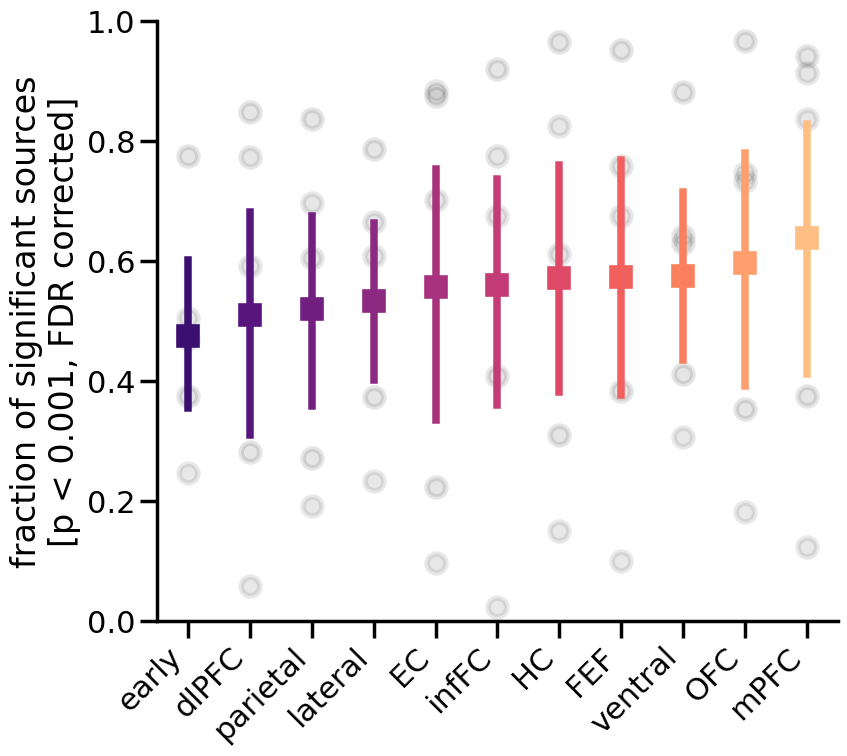

Figure saved as: pac_fraction_per_roi_3-8_40-140_0.15-0.4_fdr.png and pac_fraction_per_roi_3-8_40-140_0.15-0.4_fdr.pdf


In [239]:
# Create visualisation of significant fraction per ROI
order = sig_fraction.groupby("area")["significant_fdr"].mean().sort_values(ascending=True).index
palette = sns.color_palette("magma", n_colors=len(compound_labels.keys())+3)[2:-1]
# leave out EC
#sig_fraction = sig_fraction[sig_fraction["area"] != "EC"]
plt.figure(figsize=(9, 8))
sns.pointplot(
    data=sig_fraction, 
    x="area", 
    y="significant_fdr",
    order=order,color="k", alpha=0.1, hue="subject",
    ci=0, markers="o", join=None, legend=False
    )
sns.pointplot(
    data=sig_fraction, 
    x="area", 
    y="significant_fdr", 
    order=order, 
    palette=palette,
    ci=95, markers="s")

    #errcolor="grey")
# how many (fraction) accidental significant sources would we expect by chance? (5/100, i.e., 5% for p<0.05, and 1/1000 for p<0.001)


#plt.axhline(y=chance_level_fraction, color="grey", linestyle="--", alpha=0.7, label="Chance level (0.1%)")
plt.ylabel(f"fraction of significant sources\n[p < {p_threshold}, FDR corrected]")
plt.xlabel("")
plt.xticks(rotation=45, ha='right')
plt.legend(loc="upper right", frameon=False)
#plt.title("Phase-Amplitude Coupling by Brain Region")
plt.tight_layout()
#despine()
sns.despine()
# set y limit
plt.ylim(0, 1)
# Save figure
fname = f"pac_fraction_per_roi_{theta_freqs[0]}-{theta_freqs[1]}_{gamma_freqs[0]}-{gamma_freqs[1]}_{time_window[0]}-{time_window[1]}_fdr"
plt.savefig(fname + ".png", dpi=300, bbox_inches='tight')
plt.savefig(fname + ".pdf", dpi=300, bbox_inches='tight')
plt.show()

print(f"Figure saved as: {fname}.png and {fname}.pdf")

## Visualisation: Mean PAC Values

Plot the mean PAC z-scores by brain region and hemisphere.

/var/folders/27/cgtzfw9j75bc116gkfsr71v00000gn/T/ipykernel_66070/1241230674.py:6: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.pointplot(
/var/folders/27/cgtzfw9j75bc116gkfsr71v00000gn/T/ipykernel_66070/1241230674.py:6: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(


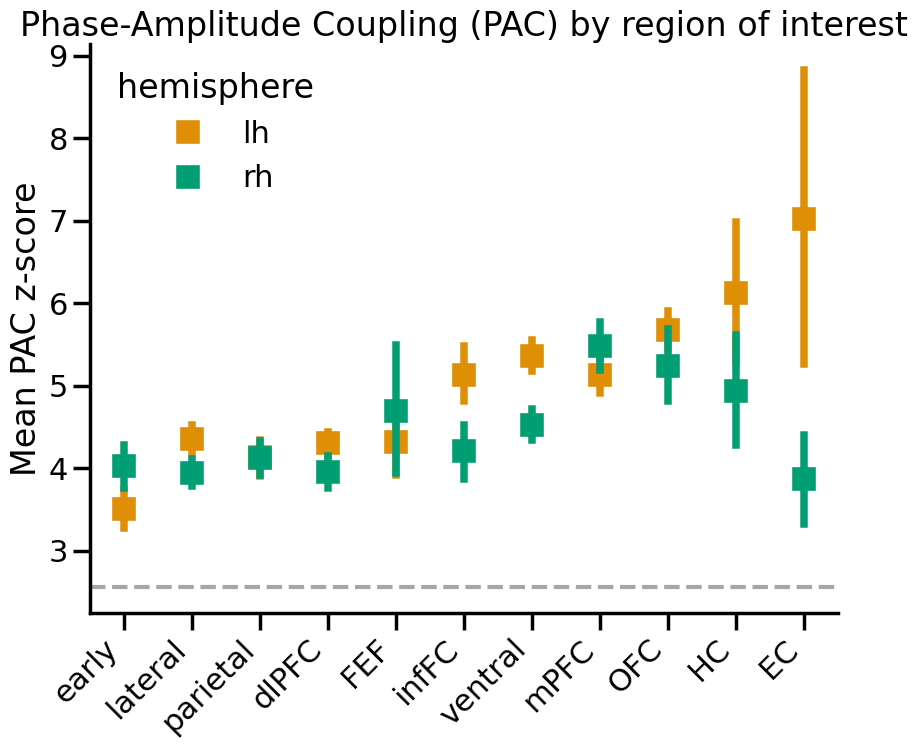

Figure saved as: pac_values_per_roi_3-8_40-140_0.15-0.4.png and pac_values_per_roi_3-8_40-140_0.15-0.4.pdf

Mean PAC values by region:
           mean    std  count
area                         
EC        5.645  6.431    140
HC        5.639  5.067    287
OFC       5.559  4.130   1504
mPFC      5.293  3.890   1730
ventral   4.921  3.805   3062
infFC     4.706  3.930   1090
FEF       4.507  3.165    211
dlPFC     4.143  3.378   2994
parietal  4.133  3.191   1652
lateral   4.132  3.149   2606
early     3.758  3.301   1412


In [238]:
# Create visualisation of mean PAC values per ROI
plt.figure(figsize=(9, 8))
order_pac = pac_per_label.groupby("area")["PAC"].mean().sort_values(ascending=True).index
palette_cb = sns.color_palette("colorblind", n_colors=10)[1:-1]

sns.pointplot(
    data=pac_per_label,
    x="area",
    y="PAC", 
    hue="hemi",
    order=order_pac,
    palette=palette_cb,
    ci=95,
    #errcolor="grey",
    join=False, markers=("s")
)

plt.ylabel("Mean PAC z-score")
plt.xlabel("")
plt.xticks(rotation=45, ha='right')
plt.title("Phase-Amplitude Coupling (PAC) by region of interest")
plt.legend(frameon=False, title="hemisphere")
plt.tight_layout()
# despine
sns.despine()
# sig level
plt.axhline(y=threshold_z, color="grey", linestyle="--", alpha=0.7, label="p < 0.001", zorder = 0)

# Save figure
fname = f"pac_values_per_roi_{theta_freqs[0]}-{theta_freqs[1]}_{gamma_freqs[0]}-{gamma_freqs[1]}_{time_window[0]}-{time_window[1]}"
plt.savefig(fname + ".png", dpi=300, bbox_inches='tight')
plt.savefig(fname + ".pdf", dpi=300, bbox_inches='tight')
plt.show()

print(f"Figure saved as: {fname}.png and {fname}.pdf")

# Print summary statistics
print("\nMean PAC values by region:")
mean_pac_summary = pac_per_label.groupby("area")["PAC"].agg(['mean', 'std', 'count']).round(3)
mean_pac_summary = mean_pac_summary.sort_values('mean', ascending=False)
print(mean_pac_summary)

In [131]:
if use_dursplit:
    print("=" * 60)
    print("Duration Split Analysis - Data Preparation")
    print("=" * 60)
    
    # Extract PAC values for shorter_dur and longer_dur groups
    pac_dur_comparison = []
    
    for subject in subjects:
        pac_results = pac_results_dict[subject]
        
        if 'split_group' not in pac_results.columns:
            print(f"Subject {subject}: No split_group column, skipping")
            continue
        
        # Get shorter and longer duration data
        shorter_dur = pac_results[pac_results['split_group'] == 'short_dur'].copy()
        longer_dur = pac_results[pac_results['split_group'] == 'long_dur'].copy()
        
        print(f"\nSubject {subject}: {len(shorter_dur)} shorter_dur, {len(longer_dur)} longer_dur sources")
        
        # Merge on channel to get paired comparisons
        merged = pd.merge(
            shorter_dur[['channel', 'pac']], 
            longer_dur[['channel', 'pac']], 
            on='channel', 
            suffixes=('_shorter', '_longer')
        )
        
        merged['subject'] = subject
        merged['pac_diff'] = merged['pac_longer'] - merged['pac_shorter']
        pac_dur_comparison.append(merged)
        print(pac_dur_comparison)
    # Concatenate all subjects
    if pac_dur_comparison:
        pac_dur_df = pd.concat(pac_dur_comparison, ignore_index=True)
        
        print(f"\n{'-'*60}")
        print(f"Paired comparison results:")
        print(f"  Total paired sources: {len(pac_dur_df)}")
        print(f"  Mean PAC (shorter dur): {pac_dur_df['pac_shorter'].mean():.3f} ± {pac_dur_df['pac_shorter'].std():.3f}")
        print(f"  Mean PAC (longer dur): {pac_dur_df['pac_longer'].mean():.3f} ± {pac_dur_df['pac_longer'].std():.3f}")
        print(f"  Mean difference (longer - shorter): {pac_dur_df['pac_diff'].mean():.3f} ± {pac_dur_df['pac_diff'].std():.3f}")
        
        # === ADD ROI INFORMATION ===
        print(f"\n{'-'*60}")
        print("Adding ROI information to duration comparison...")
        
        # Create a mapping from channel to ROI for each subject (reuse if already created)
        if 'roi_map_df' not in locals():
            channel_to_roi = []
            for subject in subjects:
                stc = stc_dict[subject]
                subject_labels = labels_dict[subject]
                
                for area, labels in subject_labels.items():
                    for hemi, labels_list in labels.items():
                        for label in labels_list:
                            # Extract vertices in this label
                            stc_label = stc.in_label(label)
                            hemi_idx = 0 if hemi == "lh" else 1
                            valid_vertices = stc_label.vertices[hemi_idx]
                            
                            # Get channel indices for these vertices
                            vertices_idx = np.where(np.isin(stc.vertices[hemi_idx], valid_vertices))[0]
                            if hemi == "rh":
                                vertices_idx += stc.vertices[0].size
                            
                            # Create mapping entries
                            for vertex_idx in vertices_idx:
                                channel_to_roi.append({
                                    'subject': subject,
                                    'channel': vertex_idx,
                                    'area': area,
                                    'hemi': hemi,
                                    'label': label.name
                                })
            
            roi_map_df = pd.DataFrame(channel_to_roi)
            print(f"Created ROI mapping for {len(roi_map_df)} channel-ROI pairs")
        else:
            print(f"Reusing existing ROI mapping ({len(roi_map_df)} channel-ROI pairs)")
        
        # Merge ROI information with duration comparison
        pac_dur_df_roi = pd.merge(
            pac_dur_df,
            roi_map_df,
            on=['subject', 'channel'],
            how='left'
        )
        
        # Remove entries without ROI information
        n_before = len(pac_dur_df_roi)
        pac_dur_df_roi = pac_dur_df_roi.dropna(subset=['area'])
        n_after = len(pac_dur_df_roi)
        print(f"Matched {n_after}/{n_before} channels to ROIs")
        
        # Compute statistics per ROI
        print(f"\n{'-'*60}")
        print("Per-ROI duration effects:")
        print(f"{'-'*60}")
        
        roi_dur_stats = []
        for area in pac_dur_df_roi['area'].unique():
            area_data = pac_dur_df_roi[pac_dur_df_roi['area'] == area]
            
            # Paired t-test per ROI
            from scipy.stats import ttest_rel
            t_stat, p_val = ttest_rel(area_data['pac_longer'], area_data['pac_shorter'])
            
            roi_dur_stats.append({
                'area': area,
                'n_sources': len(area_data),
                'mean_shorter': area_data['pac_shorter'].median(),
                'mean_longer': area_data['pac_longer'].median(),
                'mean_diff': area_data['pac_diff'].median(),
                'std_diff': area_data['pac_diff'].std(),
                't_stat': t_stat,
                'p_val': p_val
            })
        
        roi_dur_stats_df = pd.DataFrame(roi_dur_stats).sort_values('mean_diff', ascending=False)
        
        # FDR correction
        _, fdr_p_vals = mne.stats.fdr_correction(roi_dur_stats_df['p_val'].values, alpha=0.05)
        roi_dur_stats_df['fdr_p_val'] = fdr_p_vals
        roi_dur_stats_df['significant_fdr'] = fdr_p_vals < 0.05
        
        print(roi_dur_stats_df[['area', 'n_sources', 'mean_shorter', 'mean_longer', 'mean_diff', 't_stat', 'p_val', 'fdr_p_val']].to_string(index=False))
        
        # Count significant ROIs
        n_sig = roi_dur_stats_df['significant_fdr'].sum()
        print(f"\nFDR-significant ROIs [q < 0.05]: {n_sig}/{len(roi_dur_stats_df)}")
        
        if n_sig > 0:
            print(f"\nSignificant ROIs:")
            sig_rois = roi_dur_stats_df[roi_dur_stats_df['significant_fdr']]
            print(sig_rois[['area', 'mean_diff', 't_stat', 'fdr_p_val']].to_string(index=False))
        
        print(f"\nDuration split data prepared: pac_dur_df_roi ({len(pac_dur_df_roi)} observations)")
    else:
        print("\nNo duration split data available")
else:
    print("Duration split data not requested (use_dursplit=False)")


Duration Split Analysis - Data Preparation

Subject 1: 7960 shorter_dur, 7960 longer_dur sources
[      channel  pac_shorter  pac_longer  subject  pac_diff
0           0     4.804874    6.259508        1  1.454633
1           1     0.581457    9.183312        1  8.601855
2           2     2.522851    4.894912        1  2.372061
3           3     0.178066    5.031461        1  4.853395
4           4     0.822095    4.798119        1  3.976024
...       ...          ...         ...      ...       ...
7955     7955     0.882758    2.154708        1  1.271950
7956     7956     1.806542    0.735648        1 -1.070893
7957     7957     2.021010    0.597345        1 -1.423665
7958     7958    -0.280959    1.732284        1  2.013243
7959     7959     1.783259    1.705516        1 -0.077743

[7960 rows x 5 columns]]

Subject 2: 3560 shorter_dur, 3560 longer_dur sources
[      channel  pac_shorter  pac_longer  subject  pac_diff
0           0     4.804874    6.259508        1  1.454633
1        

In [131]:
# how many sources does this affect per subject? [pac_dur_df['pac_longer'] > 1.56]
print(f"\n{'='*60}")
print(pac_dur_df[pac_dur_df['pac_longer'] < 1.56].groupby('subject').size(), "sources with pac < 1.56 in longer dur")
# what is the fraction of sources with pac < 1.56 in longer dur?
print(pac_dur_df[pac_dur_df['pac_longer'] < 1.56].groupby('subject').size() / pac_dur_df.groupby('subject').size(), "fraction of sources with pac < 1.56 in longer dur")


subject
1    6743
2    1706
3    2043
4    1100
5    3813
dtype: int64 sources with pac < 1.56 in longer dur
subject
1    0.822718
2    0.208150
3    0.254770
4    0.134212
5    0.465284
dtype: float64 fraction of sources with pac < 1.56 in longer dur



Creating visualisations for duration comparison...
   channel  pac_shorter  pac_longer  subject  pac_diff  joint_mask
0        0     4.804874    6.259508        1  1.454633        True
1        1     0.581457    9.183312        1  8.601855        True
2        2     2.522851    4.894912        1  2.372061        True
3        3     0.178066    5.031461        1  4.853395        True
4        4     0.822095    4.798119        1  3.976024        True
  Selected 4791 sources
  Selected 3407 sources
  Selected 7726 sources
  Selected 7854 sources
  Selected 6338 sources
   channel  pac_shorter  pac_longer  subject  pac_diff  joint_mask
0        0     4.804874    6.259508        1  1.454633        True
1        1     0.581457    9.183312        1  8.601855        True
2        2     2.522851    4.894912        1  2.372061        True
3        3     0.178066    5.031461        1  4.853395        True
4        4     0.822095    4.798119        1  3.976024        True
       channel  pac_shor

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


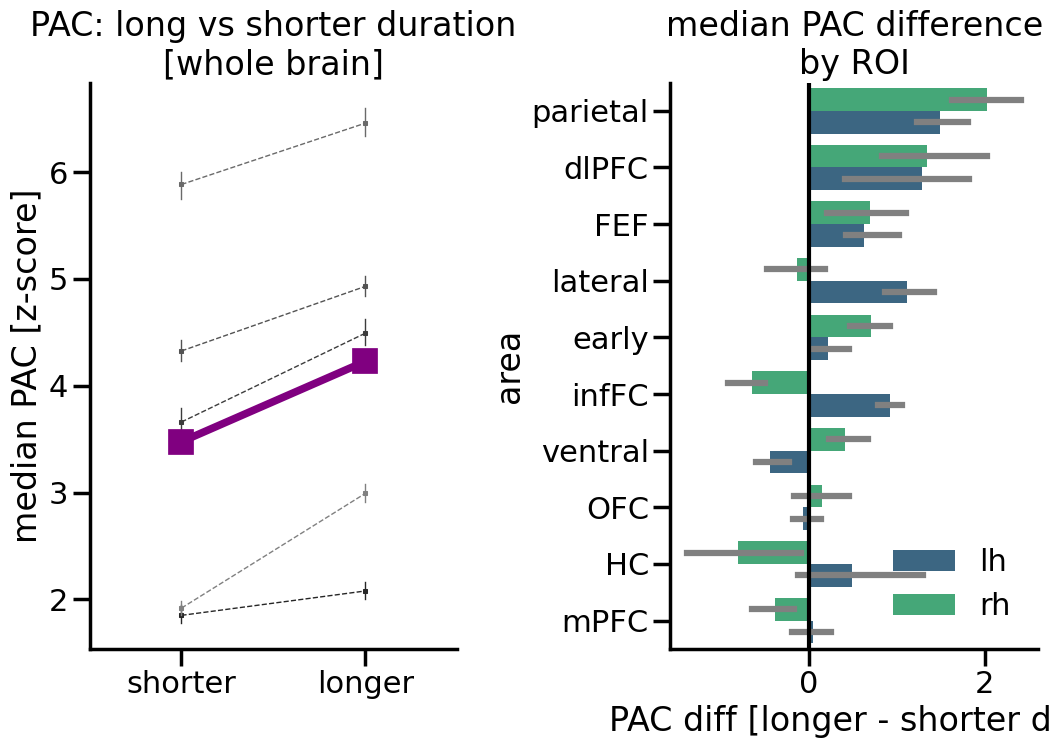

Available ROIs: ['early' 'parietal' 'lateral' 'ventral' 'HC' 'FEF' 'mPFC' 'dlPFC' 'infFC'
 'OFC']


Text(0, 0.5, 'median PAC [z-score]')

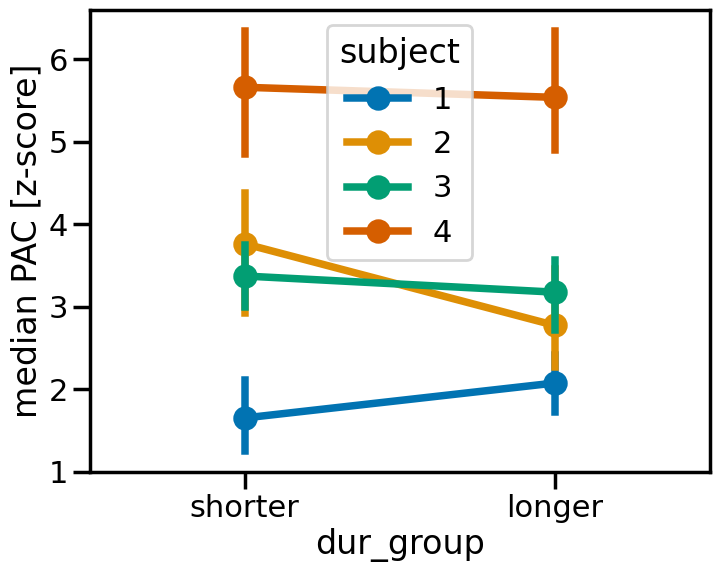

In [241]:
# make a pointplot for duration comparison per subject and another per ROI

print("\nCreating visualisations for duration comparison...")
print("=" * 50)
# remove EC from pac_dur_df_roi
pac_dur_df_roi = pac_dur_df_roi[pac_dur_df_roi["area"] != "EC"]

print(pac_dur_df.head())


# determine threshold for top 50% per subject
pac_dur_df["joint_mask"] = False
for subject in subjects:
    sub_data = pac_dur_df[pac_dur_df['subject'] == subject]
    # which sources are sign in shorter dur?
    threshold = (sub_data['pac_shorter'] > 0) & (sub_data['pac_longer'] > 0)
    pac_dur_df.loc[(pac_dur_df['subject'] == subject) & threshold, 'joint_mask'] = True
    #print(f"Subject {subject}: threshold for top 50% combined PAC = {threshold:.3f}")
    print(f"  Selected {pac_dur_df.loc[(pac_dur_df['subject'] == subject) & (pac_dur_df['joint_mask'])].shape[0]} sources")
# Overall comparison plot
fig, axes = plt.subplots(1, 2, figsize=(11, 8))
print(pac_dur_df.head())
# Panel 1: Overall comparison
print(pac_dur_df)
# filter for sources that have signficant long duration pac
pac_dur_longer = pd.melt(
    pac_dur_df[pac_dur_df['joint_mask']],
    id_vars=['subject', 'channel'], 
    value_vars=['pac_shorter', 'pac_longer'],
    var_name='dur_group', 
    value_name='pac'
)


pac_dur_longer['dur_group'] = pac_dur_longer['dur_group'].map({'pac_shorter': 'shorter', 'pac_longer': 'longer'})
print(pac_dur_longer.head())
sns.pointplot(data=pac_dur_longer, x='dur_group', y='pac', color='grey', ax=axes[0],
                errorbar=('ci', 99), hue="subject", legend=False, linewidth=1, linestyles='--', markers='s',
                # median and IQR
                estimator=np.median)
sns.pointplot(data=pac_dur_longer, x='dur_group', y='pac', ax=axes[0],
                errorbar=('ci', 99), legend=False, linewidth=5.5,
                # median and IQR
                estimator=np.median, markers='s', ci=95, color="purple")
#axes[0].scatter([0, 1], [grand_avg_shorter, grand_avg_longer], 
                #color='black', s=100, label='Grand Median', zorder=10, marker='D')
axes[0].set_ylabel('median PAC [z-score]')
axes[0].set_xlabel('')
axes[0].set_title(f'PAC: long vs shorter duration\n[whole brain]')
axes[0].legend(title="sub", frameon=False, loc='lower right')
# despine
sns.despine(ax=axes[0])

# plot the grand average as a line
axes[0].legend(frameon=False, loc='lower right')

# Panel 2: Per-ROI comparison
axes[0].set_xlim(-0.5, 1.5)
# Bar plot of mean differences per ROI (use the pac_dur_longer)
#roi_order = pac_dur_df_roi.groupby("area")["pac_diff"].median().sort_values(ascending=True).index
sns.barplot(data=pac_dur_df_roi,
            y='area',
            x='pac_diff',
            order=pac_dur_df_roi.groupby("area")["pac_diff"].median().sort_values(ascending=True).index,
            ci=95,
            errcolor="grey",
            palette='viridis',
            ax=axes[1],
            hue='hemi',
            estimator=np.median, orient='h'
           )
# invert y axis
axes[1].invert_yaxis()
axes[1].set_yticks(range(len(roi_order)))
axes[1].set_yticklabels(roi_order)
axes[1].axvline(x=0, color='black', linestyle='-')
axes[1].set_xlabel('PAC diff [longer - shorter dur]')
#axes[1].set_ylabel('Brain Region')
axes[1].set_title('median PAC difference\nby ROI')
# despine
axes[1].legend(frameon=False, loc ='lower right')
sns.despine(ax=axes[1])
fname = f"pac_dur_comparison_{theta_freqs[0]}-{theta_freqs[1]}_{gamma_freqs[0]}-{gamma_freqs[1]}"

# tight layout
plt.tight_layout()
plt.savefig(fname + ".png", dpi=300, bbox_inches='tight')
plt.savefig(fname + ".pdf", dpi=300, bbox_inches='tight')
plt.show()



# make a new figure (the same principle as the first subpanel above but now by subselecting for a set of ROIs
plt.figure(figsize=(8, 6))
# which rois do we have?
print("Available ROIs:", pac_dur_df_roi['area'].unique())
# select a few ROIs to plot
selected_rois = ["early"]
pac_dur_longer_roi = pd.melt(
    pac_dur_df_roi[pac_dur_df_roi['area'].isin(selected_rois)],
    id_vars=['subject', 'channel', 'area'], 
    value_vars=['pac_shorter', 'pac_longer'],
    var_name='dur_group', 
    value_name='pac'
)
pac_dur_longer_roi['dur_group'] = pac_dur_longer_roi['dur_group'].map({'pac_shorter': 'shorter', 'pac_longer': 'longer'})
sns.pointplot(data=pac_dur_longer_roi, x='dur_group', y='pac', hue='subject',
                palette='colorblind',
                errorbar=('ci', 99),
                estimator=np.median)
plt.ylabel('median PAC [z-score]')


## Duration Split Analysis (if available)

Test effects of fixation duration (short vs long) on PAC using linear mixed models.

## Mixed-Effects Models per ROI and Hemisphere

Test memorability effects in each brain region and hemisphere using linear mixed models with subject as random effect.

## Memorability Split Analysis (if available)

If the data contains memorability split groups (high_mem vs low_mem), perform comparison analysis per source.

## Brain Visualisation Functions

Create functions for consistent brain plotting.

In [138]:
def plot_brain_results(stc, subjects_dir, save_name=None, colormap='magma', 
                      surface='pial', views='lateral'):
    """
    Plot brain results with consistent parameters.
    
    Parameters
    ----------
    stc : mne.SourceEstimate
        Source estimate to plot
    subjects_dir : str
        Path to subjects directory
    save_name : str, optional
        Filename to save (without extension)
    colormap : str
        Colormap to use
    surface : str
        Brain surface type
    views : str
        Brain view angle
        
    Returns
    -------
    brain : mne.viz.Brain
        Brain plot object
    """
    vmin, vmid, vmax = -4, 0, 4
    
    brain = stc.plot(
        subjects_dir=subjects_dir,
        initial_time=0,
        hemi='split',
        time_viewer=False,
        colorbar=False,
        colormap=colormap,
        size=(900, 450),
        clim=dict(kind='value', lims=[vmin, vmid, vmax]),
        smoothing_steps=2,
        transparent=False,
        surface=surface,
        background="white",
        views=views
    )
    
    if save_name:
        brain.save_image(f"{save_name}.png")
        print(f"Brain plot saved as: {save_name}.png")
    
    return brain


def create_colorbar(vmin, vmid, vmax, colormap='magma', orientation='horizontal'):
    """
    Create a standalone colorbar for brain plots.
    """
    fig, ax = plt.subplots(1, 1, figsize=(5.5, 3.4))
    
    mne.viz.plot_brain_colorbar(
        ax, 
        clim=dict(kind="value", lims=[vmin, vmid, vmax]), 
        colormap=colormap, 
        transparent=False, 
        orientation=orientation
    )
    
    # Customise colorbar
    x = np.linspace(vmin, vmax, 3)
    ax.set_xticks(x)
    ax.set_xticklabels([f"{i:.1f}" for i in x])
    ax.set_xlabel("PAC z-score")
    ax.tick_params(tick1On=False)
    
    fig.set_dpi(300)
    fig.tight_layout()
    
    return fig, ax

print("Brain visualisation functions defined.")

Brain visualisation functions defined.


## Brain Visualisation: Average PAC

Plot the average PAC across all subjects on the brain surface.

In [171]:
# Plot average PAC across all subjects
print("Creating brain visualisation...")

# Generate multiple views
views = ['lateral', 'medial']
surfaces = ['pial',]# 'inflated']
cmap = 'icefire'
try:
    for surface in surfaces:
        for view in views:
            save_name = f"pac_average_{event_types[0]}_{theta_freqs[0]}-{theta_freqs[1]}_{gamma_freqs[0]}-{gamma_freqs[1]}_{surface}_{view}"
            
            brain = plot_brain_results(
                average_stc, 
                SUBJECTS_DIR, 
                save_name=save_name,
                surface=surface,
                views=view, colormap=cmap
            )
            
            # Close brain to save memory
            brain.close()
    
    print("Brain plots created for all surface/view combinations.")
except Exception as e:
    print(f"Error creating brain plots: {e}")
    print("Brain visualisation requires proper MNE setup and subjects directory.")

Creating brain visualisation...
Brain plot saved as: pac_average_saccade_3-8_40-140_pial_lateral.png
Brain plot saved as: pac_average_saccade_3-8_40-140_pial_medial.png
Brain plots created for all surface/view combinations.


## Create Standalone Colorbar

Generate a colorbar for use in figures and presentations.

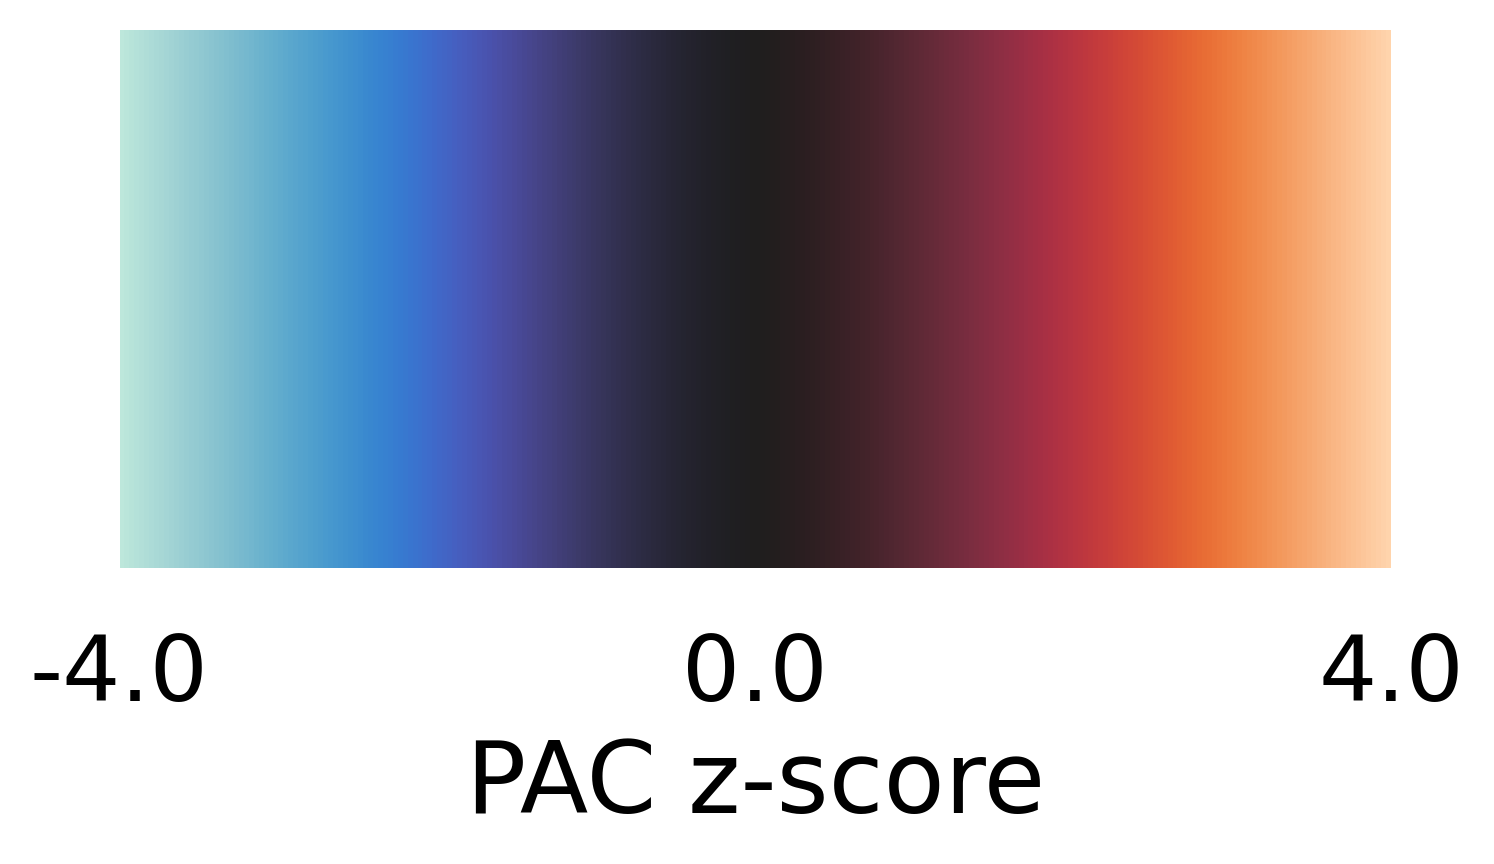

Colorbar saved as: colorbar_vmin_-4_vmid_0_vmax_4.png and colorbar_vmin_-4_vmid_0_vmax_4.pdf


In [170]:
# Create colorbar
vmin, vmid, vmax = -4, 0, 4
cmap = 'icefire'
try:
    fig, ax = create_colorbar(vmin, vmid, vmax, colormap=cmap, orientation='horizontal')
    
    # Save colorbar
    colorbar_name = f"colorbar_vmin_{vmin}_vmid_{vmid}_vmax_{vmax}"
    fig.savefig(f"{colorbar_name}.png", transparent=True, dpi=300, bbox_inches='tight')
    fig.savefig(f"{colorbar_name}.pdf", transparent=True, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Colorbar saved as: {colorbar_name}.png and {colorbar_name}.pdf")
except Exception as e:
    print(f"Error creating colorbar: {e}")
    print("Creating simple colorbar instead...")
    
    # Simple colorbar creation
    fig, ax = plt.subplots(figsize=(6, 1))
    cmap = plt.cm.icefire
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), 
                       cax=ax, orientation='horizontal')
    cbar.set_label('PAC z-score')
    plt.tight_layout()
    plt.show()

In [76]:
# random integer from 1 to 4
import random
rand_int = random.randint(1, 4)
print(f"Random integer (1-4): {rand_int}")

Random integer (1-4): 3
